### Importing libraries

In [3]:
import pandas as pd
import datetime
import pandasql as psql
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('sales_20_21_train.csv', 
                parse_dates = ['ds'], 
                names = ['sell_id','ds','store','qty','value','client_id','channel'],
                header = 0)

df_sample_submission = pd.read_csv('sample_submission.csv',
                                    names = ['client_id','value'],
                                    header = 0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630612 entries, 0 to 1630611
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   sell_id    1630612 non-null  int64         
 1   ds         1630612 non-null  datetime64[ns]
 2   store      1630612 non-null  int64         
 3   qty        1630612 non-null  int64         
 4   value      1630612 non-null  float64       
 5   client_id  1630612 non-null  int64         
 6   channel    1630612 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 87.1+ MB


### Info about transaction dataset

In [6]:
print('Total transactions: ' + str(df.shape[0]))
print('Highest transaction: R$' + str(df.value.max()))
print('Average ticket: R${:2.2f}'.format(df.value.mean()))
print('First transaction: ' + str(df.ds.min()))
print('Last transaction: ' + str(df.ds.max()))
print('Max products purchased: ' + str(df.qty.max()))
print('Average products per purchase: ' + str(df.qty.mean()))
print('Distinct sales channels: ' + str(df.channel.nunique()))
print('Distinct stores: ' + str(df.store.nunique()))

Total transactions: 1630612
Highest transaction: R$21390.47
Average ticket: R$80.75
First transaction: 2020-01-02 00:00:00
Last transaction: 2021-02-24 00:00:00
Max products purchased: 98
Average products per purchase: 5.0186893019308085
Distinct sales channels: 5
Distinct stores: 52


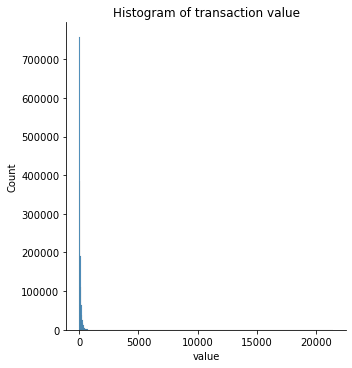

In [7]:
sns.displot(data = df, x = 'value', bins = 500).set(title = 'Histogram of transaction value')

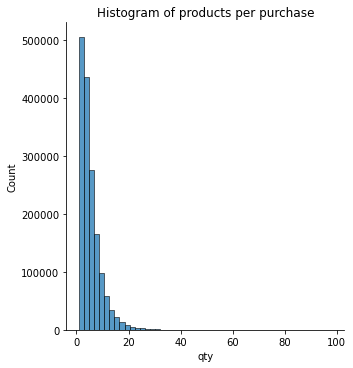

In [8]:
sns.displot(data = df, x = 'qty', bins = 50).set(title = 'Histogram of products per purchase')

In [9]:
#por dia
df_graph = df.copy()
df_graph['month'] = df_graph.ds.dt.strftime('%Y-%m')

In [10]:
#por dia
df_day = df_graph.groupby('month').agg({'value':['sum','mean'],
                               'qty':['sum','mean'],
                               'sell_id':'count'}).reset_index()

df_day.columns = ['month','revenue','avg_revenue','sum_products','avg_products','n_transactions']
df_day['revenue_per_product'] = df_day.revenue/df_day.sum_products

#por dia e canal
df_day_channel = df_graph.groupby(['month','channel']).agg({'value':['sum','mean'],
                               'qty':['sum','mean'],
                               'sell_id':'count'}).reset_index()
df_day_channel.columns = ['month','channel','revenue','avg_revenue','sum_products','avg_products','n_transactions']

#por dia e loja
df_day_store = df_graph.groupby(['month','store']).agg({'value':['sum','mean'],
                               'qty':['sum','mean'],
                               'sell_id':'count'}).reset_index()
df_day_store.columns = ['month','store','revenue','avg_revenue','sum_products','avg_products','n_transactions']
df_day_store['revenue_per_product'] = df_day_store.revenue/df_day_store.sum_products

Text(0.5, 1.0, 'Total transactions per month')

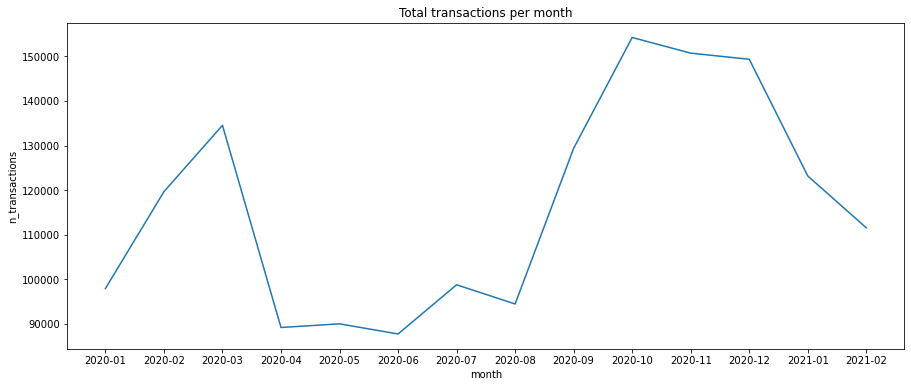

In [11]:
plt.figure(figsize = (15,6))
sns.lineplot(data = df_day, x ='month', y = 'n_transactions').set_title("Total transactions per month")

Text(0.5, 1.0, 'Revenue per month')

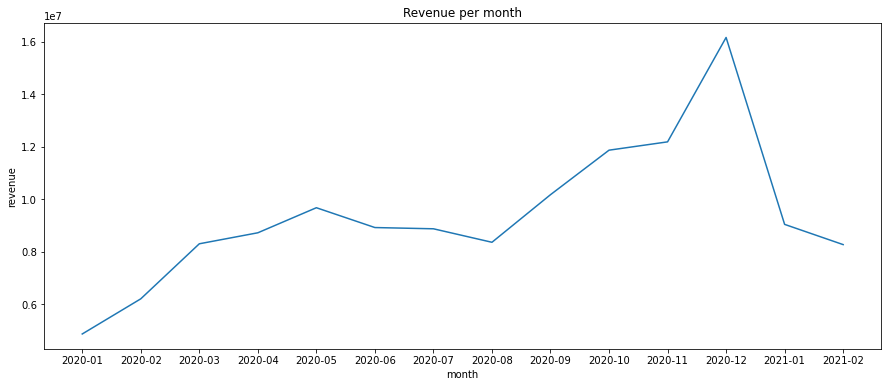

In [12]:
plt.figure(figsize = (15,6))
sns.lineplot(data = df_day, x ='month', y = 'revenue').set_title("Revenue per month")

Text(0.5, 1.0, 'Revenue per month - Split by channel')

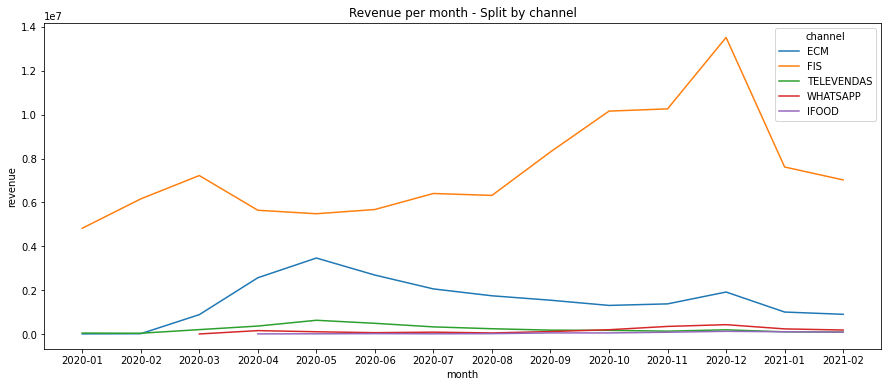

In [13]:
plt.figure(figsize = (15,6))
sns.lineplot(data = df_day_channel, x ='month', y = 'revenue', hue = 'channel').set_title("Revenue per month - Split by channel")

Text(0.5, 1.0, 'Average products per purchase')

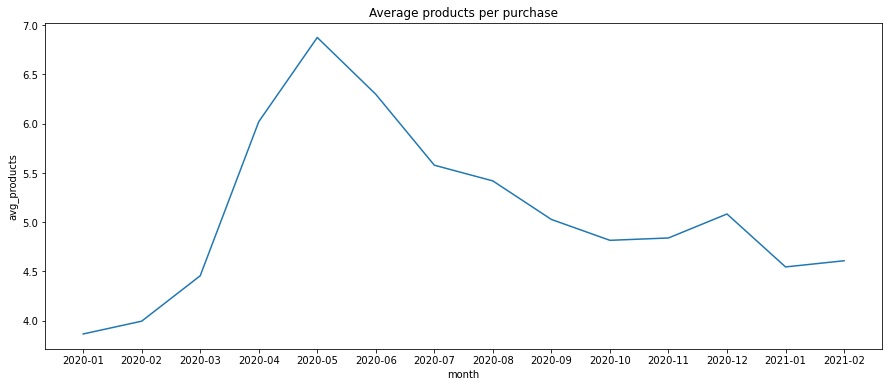

In [14]:
plt.figure(figsize = (15,6))
sns.lineplot(data = df_day, x ='month', y = 'avg_products').set_title("Average products per purchase")

Text(0.5, 1.0, 'Average revenue per product')

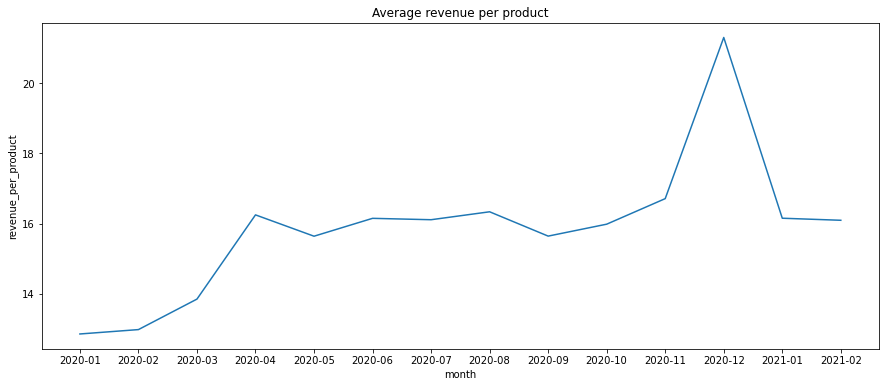

In [15]:
plt.figure(figsize = (15,6))
sns.lineplot(data = df_day, x ='month', y = 'revenue_per_product').set_title("Average revenue per product")

Text(0.5, 1.0, 'Average revenue per product- Split by a store')

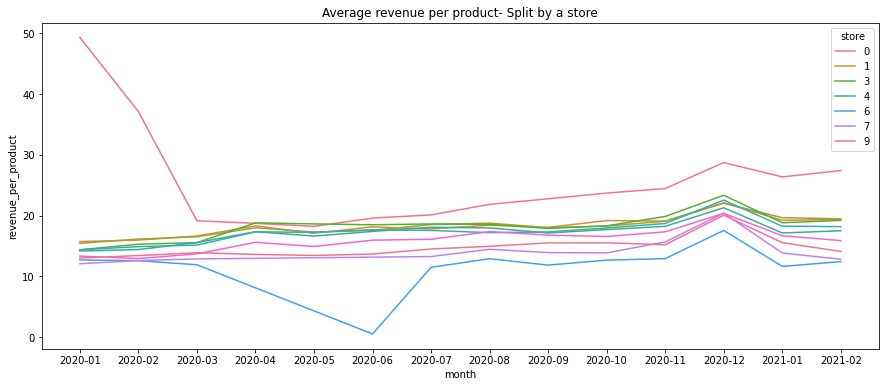

In [16]:
plt.figure(figsize = (15,6))
sns.lineplot(data = df_day_store[df_day_store.store < 10], x ='month', y = 'revenue_per_product', hue = 'store', palette='husl').set_title("Average revenue per product- Split by a store")

### Info about the client base

In [17]:
df_client = df.groupby('client_id').agg({'value':['count','sum','mean'],
                                         'qty':['sum','mean'],
                                         'ds':['min','max']}).reset_index()

df_client.columns = ['client_id','transactions','ltv','avg_ticket','sum_products',
                     'avg_products','first_transaction','last_transaction']

df_client['tenure'] = (datetime.datetime(2021,2,24) - df_client.first_transaction).dt.days
df_client['days_active'] = (df_client.last_transaction - df_client.first_transaction).dt.days

In [18]:
print('Total clients: ' + str(df_client.shape[0]))
print('Client with highest LTV: R$' + str(df_client.ltv.max()))
print('Average LTV per client: R${:2.2f}'.format(df_client.ltv.mean()))
print('Client with most transactions: ' + str(df_client.transactions.max()))
print('Average transactions per client: {:2.2f}'.format(df_client.transactions.mean()))
print('% of clients with more than one transaction: {:2.2f}'.format(df_client[df_client.transactions > 1].shape[0]/df_client.shape[0]))
print('Oldest client (days): ' + str(df_client.tenure.max()))
print('Youngest client (days): ' + str(df_client.tenure.min()))
print('Average client tenure (days): {:2.2f}'.format(df_client.tenure.mean()))
print('Client with most days active: ' + str(df_client.days_active.max()))
print('Average active daus per client: {:2.2f}'.format(df_client.days_active.mean()))

Total clients: 210269
Client with highest LTV: R$109963.45
Average LTV per client: R$626.18
Client with most transactions: 360
Average transactions per client: 7.75
% of clients with more than one transaction: 0.81
Oldest client (days): 419
Youngest client (days): 90
Average client tenure (days): 287.44
Client with most days active: 419
Average active daus per client: 185.39


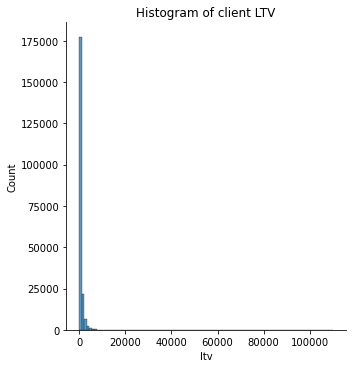

In [19]:
sns.displot(data = df_client, x = 'ltv', bins = 100).set(title = 'Histogram of client LTV')

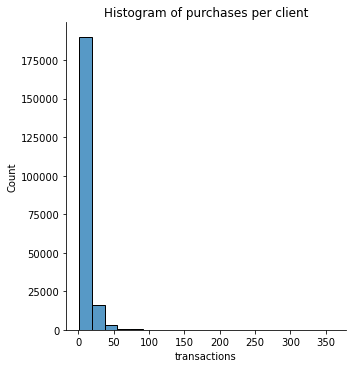

In [20]:
sns.displot(data = df_client, x = 'transactions', bins = 20).set(title = 'Histogram of purchases per client')

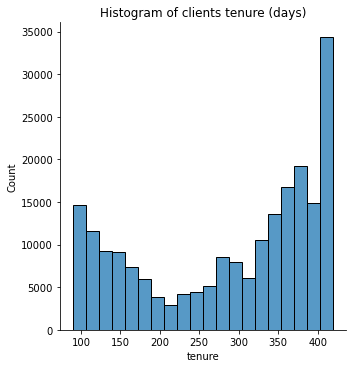

In [21]:
sns.displot(data = df_client, x = 'tenure', bins = 20).set(title = 'Histogram of clients tenure (days)')

### Relation between a few variables

In [22]:
df_enriched = df.merge(df.groupby('client_id').agg({'ds':'min'}).rename(columns = {'ds':'first_transaction'}), left_on = 'client_id', right_index= True, how = 'left')

In [23]:
df_enriched['first_30d'] = ((df_enriched.ds - df_enriched.first_transaction).dt.days <=30)*df_enriched.value
df_enriched['first_60d'] = ((df_enriched.ds - df_enriched.first_transaction).dt.days <=60)*df_enriched.value
df_enriched['first_90d'] = ((df_enriched.ds - df_enriched.first_transaction).dt.days <=90)*df_enriched.value

df_enriched['last_90d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 90)*df_enriched.value
df_enriched['last_120d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 120)*df_enriched.value
df_enriched['last_150d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 150)*df_enriched.value
df_enriched['last_180d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 180)*df_enriched.value
df_enriched['last_270d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 270)*df_enriched.value

df_enriched['t_last_90d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 90)*1
df_enriched['t_last_120d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 120)*1
df_enriched['t_last_150d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 150)*1
df_enriched['t_last_180d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 180)*1
df_enriched['t_last_270d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 270)*1

df_enriched['p_last_90d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 90)*df_enriched.qty
df_enriched['p_last_120d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 120)*df_enriched.qty
df_enriched['p_last_150d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 150)*df_enriched.qty
df_enriched['p_last_180d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 180)*df_enriched.qty
df_enriched['p_last_270d'] = ((datetime.datetime(2021,2,24) - df_enriched.ds).dt.days <= 270)*df_enriched.qty

In [24]:
df_client = df_enriched.groupby('client_id').agg({'value':['count','sum','mean'],
                                                  'qty':['sum','mean'],
                                                  'ds':['min','max'],
                                                  'first_30d':'sum',
                                                  'first_60d':'sum',
                                                  'first_90d':'sum',
                                                  'last_90d':'sum',
                                                  'last_120d':'sum',
                                                  'last_150d':'sum',
                                                  'last_180d':'sum',
                                                  'last_270d':'sum',
                                                  't_last_90d':'sum',
                                                  't_last_120d':'sum',
                                                  't_last_150d':'sum',
                                                  't_last_180d':'sum',
                                                  't_last_270d':'sum',
                                                  'p_last_90d':'sum',
                                                  'p_last_120d':'sum',
                                                  'p_last_150d':'sum',
                                                  'p_last_180d':'sum',
                                                  'p_last_270d':'sum'}).reset_index()

df_client.columns = ['client_id','transactions','ltv','avg_ticket','sum_products',
                     'avg_products','first_transaction','last_transaction',
                     'revenue_first_30d','revenue_first_60d','revenue_first_90d',
                     'revenue_last_90d','revenue_last_120d','revenue_last_150d','revenue_last_180d','revenue_last_270d',
                     't_last_90d','t_last_120d','t_last_150d','t_last_180d','t_last_270d',
                     'p_last_90d','p_last_120d','p_last_150d','p_last_180d','p_last_270d']

df_client['tenure'] = (datetime.datetime(2021,2,24) - df_client.first_transaction).dt.days
df_client['days_active'] = (df_client.last_transaction - df_client.first_transaction).dt.days

df_client['tenure_before'] = df_client.tenure - 90

df_client['revenue_before_all'] = df_client.ltv - df_client.revenue_last_90d
df_client['revenue_before_30d'] = df_client.revenue_last_120d - df_client.revenue_last_90d
df_client['revenue_before_60d'] = df_client.revenue_last_150d - df_client.revenue_last_90d
df_client['revenue_before_90d'] = df_client.revenue_last_180d - df_client.revenue_last_90d
df_client['revenue_before_180d'] = df_client.revenue_last_270d - df_client.revenue_last_90d

df_client['t_before_all'] = df_client.transactions - df_client.t_last_90d
df_client['t_before_30d'] = df_client.t_last_120d - df_client.t_last_90d
df_client['t_before_60d'] = df_client.t_last_150d - df_client.t_last_90d
df_client['t_before_90d'] = df_client.t_last_180d - df_client.t_last_90d
df_client['t_before_180d'] = df_client.t_last_270d - df_client.t_last_90d

df_client['p_before_all'] = df_client.sum_products - df_client.p_last_90d
df_client['p_before_30d'] = df_client.p_last_120d - df_client.p_last_90d
df_client['p_before_60d'] = df_client.p_last_150d - df_client.p_last_90d
df_client['p_before_90d'] = df_client.p_last_180d - df_client.p_last_90d
df_client['p_before_180d'] = df_client.p_last_270d - df_client.p_last_90d

<AxesSubplot:>

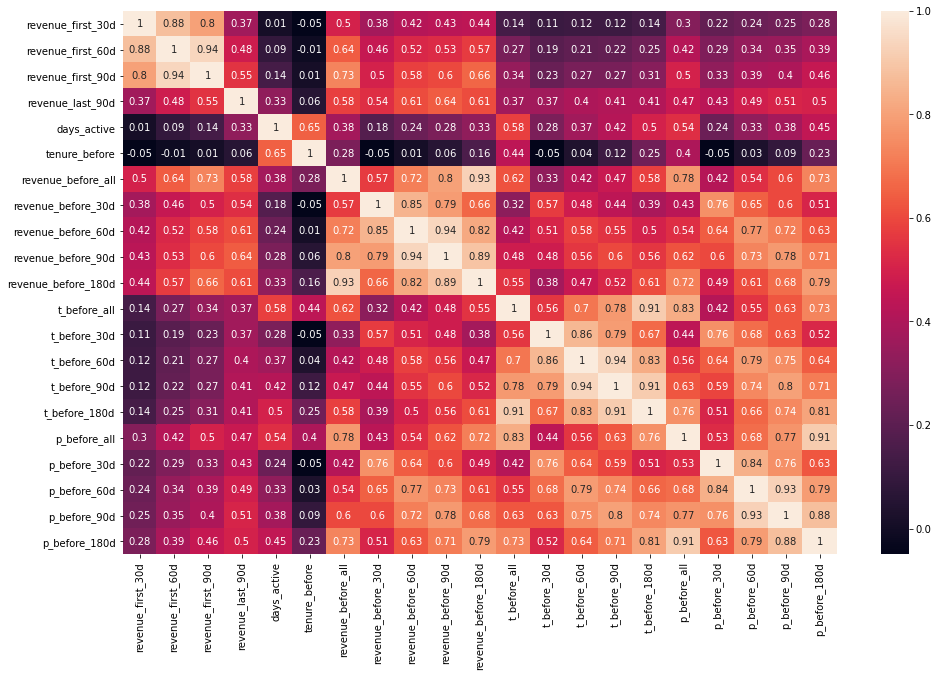

In [25]:
plt.figure(figsize = (16,10))
sns.heatmap(df_client.drop(columns = {'revenue_last_120d','revenue_last_150d','revenue_last_180d','revenue_last_270d',
                                      't_last_90d','t_last_120d','t_last_150d','t_last_180d','t_last_270d',
                                      'p_last_90d','p_last_120d','p_last_150d','p_last_180d','p_last_270d',
                                      'client_id','transactions','ltv','avg_ticket','sum_products','avg_products','tenure'}).corr().round(2), annot=True)

### Model

Used models: 
- Probabilistic model: [Lifetimes library](https://lifetimes.readthedocs.io/en/latest/Quickstart.html)
- Machine Learning model: [Catboost](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)

<img src="Model.jpg">

In [26]:
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

In [27]:
def generate_x_and_y(data, projection_start_date):
    projection_start_date = datetime.datetime.fromisoformat(projection_start_date)
    projection_final_date = projection_start_date + datetime.timedelta(days = 90)
    
    observation_df = data[data.ds < projection_start_date]
    projection_df = data[(data.ds >= projection_start_date) & (data.ds <= projection_final_date)]
    
    #gerando o y
    ltv_90d = get_revenue(projection_df,'ltv_90d')
    
    #gerando o x
    X = get_x_from_observation(observation_df, projection_start_date)
    X_prob = get_prob_data(observation_df)
    
    X = X.merge(X_prob, on = 'client_id', how = 'left')
    
    df_final = X.merge(ltv_90d, on = 'client_id', how = 'left')
    
    df_final['p_alive_x_lifetimes'] = df_final.p_alive*df_final.clv_lifetimes
    df_final['p_alive_x_pred_n_tr'] = df_final.p_alive*df_final.pred_n_tr
    
    df_final.fillna(0, inplace = True)
    return df_final
    

def get_revenue(data, column_name):
    df_revenue = data.groupby('client_id').agg({'value':'sum'}).reset_index()
    df_revenue.columns = ['client_id',column_name]
    return df_revenue

def get_x_from_observation(observation_df, projection_start_date):
    observation_final_date = projection_start_date - datetime.timedelta(days = 1)
    
    purchase_history = get_purchase_history(observation_df,projection_start_date)
    revenue_last_30d = get_revenue(observation_df[(projection_start_date - observation_df.ds).dt.days < 30], 'r_l30')
    revenue_last_60d = get_revenue(observation_df[(projection_start_date - observation_df.ds).dt.days < 60], 'r_l60')
    revenue_last_90d = get_revenue(observation_df[(projection_start_date - observation_df.ds).dt.days < 90], 'r_l90')

    X = purchase_history.merge(revenue_last_30d, on = 'client_id', how = 'left')
    X = X.merge(revenue_last_60d, on = 'client_id', how = 'left')
    X = X.merge(revenue_last_90d, on = 'client_id', how = 'left')
    
    
    X['platform_avg_price'] = observation_df[(projection_start_date - observation_df.ds).dt.days < 30].value.mean()
    X['platform_avg_products'] = observation_df[(projection_start_date - observation_df.ds).dt.days < 30].qty.mean()
    X['platform_avg_product_price'] = observation_df[(projection_start_date - observation_df.ds).dt.days < 30].value.sum()/observation_df[(projection_start_date - observation_df.ds).dt.days < 30].qty.sum()
    
    return X

def get_prob_data(data):
    df_sum = summary_data_from_transaction_data(data,'client_id','ds','value')
    bgf = BetaGeoFitter(penalizer_coef=0.1)
    bgf.fit(df_sum['frequency'], df_sum['recency'], df_sum['T'])
    
    df_sum['pred_n_tr'] = bgf.conditional_expected_number_of_purchases_up_to_time(90, 
                                                                                  df_sum['frequency'], 
                                                                                  df_sum['recency'], 
                                                                                  df_sum['T'])
    df_sum['p_alive'] = bgf.conditional_probability_alive(df_sum['frequency'], 
                                                          df_sum['recency'], 
                                                          df_sum['T'])                                                      
    
    returning_customers_summary = df_sum[df_sum.frequency > 0]
    
    ggf = GammaGammaFitter(penalizer_coef = 0)
    ggf.fit(returning_customers_summary['frequency'],
            returning_customers_summary['monetary_value'])
        
    
    df_sum['clv_lifetimes'] = ggf.customer_lifetime_value(bgf,
                                                          df_sum['frequency'],
                                                          df_sum['recency'], 
                                                          df_sum['T'],
                                                          df_sum['monetary_value'],
                                                          time = 3)
    
    df_sum = df_sum.drop(columns = {'frequency','recency','T','monetary_value'})
    return df_sum


def get_purchase_history(observation_df, projection_start_date):
    df_client = observation_df.groupby('client_id').agg({'value':['mean','max','sum'],
                                                         'qty':['mean','max','sum'],
                                                         'store':lambda x:x.value_counts().index[0],
                                                         'channel':lambda x:x.value_counts().index[0],
                                                         'ds':['min','max'],
                                                         'sell_id':'count'}).reset_index()
    
    df_client.columns = ['client_id','avg_transacted_value','max_transacted_value','total_revenue',
                         'avg_prod','max_prod','total_prod',
                         'most_frequent_store','most_frequent_channel',
                         'first_purchase','last_purchase','n_transactions']
    
    df_client['avg_product_price'] = df_client.total_revenue/df_client.total_prod
    
    ##infos de tempo
    df_client['days_since_last_purchase'] = (projection_start_date - df_client.last_purchase).dt.days
    df_client['days_active'] = (df_client.last_purchase - df_client.first_purchase).dt.days
    df_client['tenure'] = (projection_start_date - df_client.first_purchase).dt.days
    
    df_client['days_active_by_tenure'] = df_client.days_active/df_client.tenure
    df_client['days_active_by_purchase'] = df_client.days_active/df_client.n_transactions
    
    #cliente que retorna
    df_client['is_a_returnin_client'] = (df_client.n_transactions > 1)*1
    
    ##info da última compra
    df_grouped = observation_df.groupby('client_id')
    df_obs_with_rank = observation_df.copy()
    df_obs_with_rank['n_purchase'] = df_grouped['ds'].rank(method='first', ascending = False)
    df_last_purchase = df_obs_with_rank[df_obs_with_rank.n_purchase == 1]
    df_last_purchase = df_last_purchase[['client_id','store','qty','value','channel']]
    df_last_purchase.columns = ['client_id','store_lp','n_prod_lp','value_lp','channel_lp']
    
    df_client = df_client.merge(df_last_purchase, on = 'client_id', how = 'left')
    df_client['value_lp_by_max_value'] = df_client.value_lp/df_client.max_transacted_value
    
    ##receita primeiros 90d
    first_purchase = df_client[['client_id','first_purchase']]
    data_enriched = observation_df.merge(first_purchase, on = 'client_id', how = 'left')
    data_enriched = data_enriched[(data_enriched.ds - data_enriched.first_purchase).dt.days < 90]
    revenue_first_90d = data_enriched.groupby('client_id').agg({'value':'sum'}).reset_index()
    revenue_first_90d.columns = ['client_id','revenue_first_90d']
    df_client = df_client.merge(revenue_first_90d, on = 'client_id', how = 'left')
        
    return df_client
    
def get_aval_dates(data):
    min_date = data.ds.min().date()
    first_aval_date = min_date + datetime.timedelta(days = 180)
    list_dates = [first_aval_date]
    last_aval_date = datetime.date.fromisoformat('2020-11-26')
    new_date = first_aval_date
    while new_date < last_aval_date - datetime.timedelta(days = 30):
        new_date = new_date + datetime.timedelta(days = 30)
        list_dates.append(new_date)
    list_dates.append(last_aval_date)
    return list_dates

In [28]:
datetime.datetime(2021,2,24) - datetime.timedelta(days = 90)

datetime.datetime(2020, 11, 26, 0, 0)

In [29]:
list_dates = get_aval_dates(df)

In [30]:
%%time
df_model_2 = pd.DataFrame()
for date in list_dates:
    print(date)
    partial_df = generate_x_and_y(df, str(date))
    partial_df.insert(1, 'date', date)
    df_model_2 = pd.concat([df_model_2, partial_df])

2020-06-30
2020-07-30
2020-08-29
2020-09-28
2020-10-28
2020-11-26
Wall time: 20min 55s


In [31]:
df_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1006763 entries, 0 to 209143
Data columns (total 38 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   client_id                   1006763 non-null  int64         
 1   date                        1006763 non-null  object        
 2   avg_transacted_value        1006763 non-null  float64       
 3   max_transacted_value        1006763 non-null  float64       
 4   total_revenue               1006763 non-null  float64       
 5   avg_prod                    1006763 non-null  float64       
 6   max_prod                    1006763 non-null  int64         
 7   total_prod                  1006763 non-null  int64         
 8   most_frequent_store         1006763 non-null  int64         
 9   most_frequent_channel       1006763 non-null  object        
 10  first_purchase              1006763 non-null  datetime64[ns]
 11  last_purchase            

In [32]:
X = df_model_2.drop(columns = ['ltv_90d', 'client_id','date','first_purchase','last_purchase'])
y = df_model_2.ltv_90d

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
import random

In [34]:
X_test, X_train, y_test, y_train = train_test_split(X,y,random_state=16, test_size=0.33)

This model is already fitted with the best hyperparameters optimized in the following section

In [35]:
cbreg = CatBoostRegressor(cat_features=['most_frequent_store','most_frequent_channel','channel_lp','store_lp'],
                          learning_rate = 0.03,
                          depth = 9,
                          l2_leaf_reg = 9)
cbreg.fit(X_train,y_train, verbose=100, eval_set=(X_test, y_test), early_stopping_rounds=100)

0:	learn: 338.1225823	test: 324.3809053	best: 324.3809053 (0)	total: 1.25s	remaining: 20m 45s
100:	learn: 246.5935199	test: 245.4056785	best: 245.4056785 (100)	total: 1m 19s	remaining: 11m 50s
200:	learn: 239.8454105	test: 242.2971938	best: 242.2971938 (200)	total: 2m 46s	remaining: 11m 1s
300:	learn: 236.1611469	test: 241.0934560	best: 241.0934560 (300)	total: 3m 50s	remaining: 8m 55s
400:	learn: 233.4190497	test: 240.3126217	best: 240.3126217 (400)	total: 4m 53s	remaining: 7m 18s
500:	learn: 230.6149765	test: 239.8526728	best: 239.8526728 (500)	total: 6m 5s	remaining: 6m 3s
600:	learn: 228.3457196	test: 239.5045907	best: 239.5045907 (600)	total: 7m 17s	remaining: 4m 50s
700:	learn: 225.7475074	test: 239.0726933	best: 239.0726933 (700)	total: 8m 30s	remaining: 3m 37s
800:	learn: 223.8108086	test: 238.8207317	best: 238.8207317 (800)	total: 9m 40s	remaining: 2m 24s
900:	learn: 222.0772089	test: 238.6102470	best: 238.6102470 (900)	total: 10m 50s	remaining: 1m 11s
999:	learn: 220.6673009	

### Hyperparameter optimization

In [ ]:
"""
learning_rate_list = []
depth_list = []
l2_leaf_reg_list = []
rmse_test_list = []
rmse_train_list = []
"""


In [ ]:
"""
grid = {
    'learning_rate': [0.03, 0.05, 0.07, 0.09],
    'depth': [9, 10],
    'l2_leaf_reg': [5,7,9]
}
X_test, X_train, y_test, y_train = train_test_split(X,y,random_state=16, test_size=0.33)

learning_rate = random.choice(grid['learning_rate'])
depth = random.choice(grid['depth'])
l2_leaf_reg = random.choice(grid['l2_leaf_reg'])
cbreg = CatBoostRegressor(cat_features=['most_frequent_store','most_frequent_channel','channel_lp','store_lp'],
                          learning_rate=learning_rate,
                          depth = depth,
                          l2_leaf_reg = l2_leaf_reg)
cbreg.fit(X_train,
          y_train, 
          verbose=100, 
          eval_set=(X_test, y_test), 
          early_stopping_rounds=100)
rmse_test = np.sqrt(mean_squared_error(y_test, cbreg.predict(X_test)))
rmse_train = np.sqrt(mean_squared_error(y_train, cbreg.predict(X_train)))
learning_rate_list.append(learning_rate)
depth_list.append(depth)
l2_leaf_reg_list.append(l2_leaf_reg)
rmse_test_list.append(rmse_test)
rmse_train_list.append(rmse_train)

"""

In [ ]:
"""
ht = pd.DataFrame({'learning_rate_list': learning_rate_list,
             'depth_list': depth_list,
             'l2_leaf_reg_list': l2_leaf_reg_list,
             'rmse_test_list': rmse_test_list}).sort_values(by='rmse_test_list')
"""


In [55]:
pd.DataFrame(cbreg.feature_importances_, index = X.columns, columns = ['feature_importance']).sort_values(by = 'feature_importance', ascending=False)

feature_importance
r_l60                                10.816261
r_l90                                 9.510112
p_alive_x_lifetimes                   7.654339
total_prod                            6.212109
clv_lifetimes                         6.014743
r_l30                                 5.725758
avg_transacted_value                  4.887283
total_revenue                         4.541318
max_prod                              4.243665
avg_product_price                     4.110733
days_active_by_purchase               3.833433
revenue_first_90d                     3.053925
n_transactions                        2.956016
most_frequent_store                   2.522539
avg_prod                              2.388882
tenure                                2.298139
value_lp                              1.925690
channel_lp                            1.785431
max_transacted_value                  1.779591
most_frequent_channel                 1.398107
pred_n_tr                             1.385868
days_active_by_tenure                 1.325817
value_lp_by_max_value                 1.217464
days_since_last_purchase              1.212832
p_alive_x_pred_n_tr                   1.194240
days_active                           1.133049
store_lp                              1.124647
platform_avg_product_price            0.946087
p_alive                               0.876211
n_prod_lp                             0.860262
platform_avg_products                 0.663821
platform_avg_price                    0.401628
is_a_returnin_client                  0.000000

In [ ]:
mean_absolute_percentage_error(y_test, cbreg.predict(X_test))

In [ ]:
np.sqrt(mean_squared_error(y_test, cbreg.predict(X_test)))

### LTV prediction and Kaggle submission

In [36]:
df_sub = generate_x_and_y(df, '2021-02-25')

In [37]:
df_sub = df_sub[df_sub.client_id.isin(df_sample_submission.client_id)]

In [38]:
df_sub.shape

(126616, 37)

In [39]:
df_sub['client_id'].nunique()

126616

In [40]:
df_sub.head()

client_id  avg_transacted_value  max_transacted_value  total_revenue  \
3           4            115.624545                479.85        1271.87   
5           9             34.555455                137.72         380.11   
6          12             48.531739                135.89        1116.23   
9          15             86.893846                218.77        1129.62   
10         19            101.042500                120.08         404.17   

     avg_prod  max_prod  total_prod  most_frequent_store  \
3    5.636364        16          62                   12   
5    6.090909        17          67                   22   
6    5.130435        11         118                   12   
9    8.384615        23         109                   12   
10  12.500000        16          50                   19   

   most_frequent_channel first_purchase  ...   r_l90  platform_avg_price  \
3                    FIS     2020-01-17  ...  557.22             74.4709   
5                    FIS     2020-03-05  ...   31.27             74.4709   
6                    FIS     2020-01-28  ...  286.92             74.4709   
9                    FIS     2020-01-21  ...  163.14             74.4709   
10                   FIS     2020-02-29  ...    0.00             74.4709   

    platform_avg_products  platform_avg_product_price  pred_n_tr   p_alive  \
3                 4.61486                   16.137196   2.003751  0.997135   
5                 4.61486                   16.137196   2.462745  0.987304   
6                 4.61486                   16.137196   4.395890  0.996646   
9                 4.61486                   16.137196   2.651030  0.997241   
10                4.61486                   16.137196   0.811701  0.960708   

    clv_lifetimes  ltv_90d  p_alive_x_lifetimes  p_alive_x_pred_n_tr  
3      262.809713      0.0           262.056891             1.998011  
5       99.565644      0.0            98.301600             2.431479  
6      244.340298      0.0           243.520753             4.381146  
9      241.990117      0.0           241.322403             2.643715  
10      83.114230      0.0            79.848502             0.779808  

[5 rows x 37 columns]

In [41]:
df_sample_submission.shape

(126616, 2)

In [42]:
df_sub['predicted_ltv'] = cbreg.predict(df_sub.drop(columns = {'client_id','ltv_90d','first_purchase','last_purchase'}))

In [43]:
df_sub = df_sub[['client_id','predicted_ltv']]

In [44]:
df_sub.head()

client_id  predicted_ltv
3           4     342.546711
5           9      82.909274
6          12     273.643320
9          15     273.986395
10         19      86.877851

In [45]:
df_sub.shape

(126616, 2)

In [46]:
df_sub.columns = ['ID_CLIENTE','VALOR']

In [48]:
df_sub.to_csv('best_submission.csv', index = False)